In [1]:
from SFC_Jax.Fmodel import SFcalculator

In [2]:
import reciprocalspaceship as rs
import numpy as np

In [3]:
sfcalculator = SFcalculator("../data/4xof.pdb", mtzfile_dir="../data/4xof.mtz", set_experiment=True)

In [4]:
sfcalculator.inspect_data()

Solvent Percentage: 0.11279464
Grid size: [80, 120, 144]


In [7]:
Fprotein = sfcalculator.Calc_Fprotein(Print=True)

In [8]:
Fsolvent = sfcalculator.Calc_Fsolvent(Print=True, dmin_mask=6.0, dmin_nonzero=3.0)

In [10]:
Fprotein_arr = np.array(Fprotein)
Fsolvent_arr = np.array(Fsolvent)

### Compare with Phenix

In [11]:
Fcalc = rs.read_mtz('../data/4xof_vanilla.mtz')

In [12]:
Fmodel=rs.read_mtz('../data/4xof_ksol1.mtz')

In [13]:
(Fmodel.get_hkls() == Fcalc.get_hkls()).all()

True

In [14]:
calc_mag = Fcalc['FMODEL'].to_numpy()
calc_ph = np.deg2rad(Fcalc['PHIFMODEL'].to_numpy())
Fcalc_complex = np.array([complex(mag*np.cos(ph), mag*np.sin(ph)) 
                            for mag, ph in zip(calc_mag,calc_ph)])

In [15]:
model_mag = Fmodel['FMODEL'].to_numpy()
model_ph = np.deg2rad(Fmodel['PHIFMODEL'].to_numpy())
Fmodel_complex = np.array([complex(mag*np.cos(ph), mag*np.sin(ph)) 
                            for mag, ph in zip(model_mag,model_ph)])

In [16]:
Fmask_complex = Fmodel_complex - Fcalc_complex

In [17]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr,spearmanr

def linear_corr(a,b):
    reg = LinearRegression().fit(a.reshape(-1,1),b.reshape(-1,1))
    print("Linear Fit Coeff:", reg.coef_)
    print("R square:", reg.score(a.reshape(-1,1),b.reshape(-1,1)))
    print("Pearsonr:", pearsonr(a,b))
    print("Spearmanr:", spearmanr(a,b))
    
def comp_plot(mag_a, mag_b, ph_a, ph_b, name_a,name_b, dpi=None):
    fig,ax=plt.subplots(1,2,figsize=[10,4], dpi=dpi)
    ax[0].plot(mag_a, mag_b, '.', alpha=0.4)
    ax[0].set_xlabel(name_a)
    ax[0].set_ylabel(name_b)
    ax[0].set_title("Magnitude")

    ax[1].plot(ph_a, ph_b, '.', alpha=0.4)
    ax[1].set_xlabel(name_a)
    ax[1].set_ylabel(name_b)
    ax[1].set_title("Phase")
    plt.show()
    
def comp_plot_complex(a,b,name_a,name_b, dpi=None):
    fig,ax=plt.subplots(1,3,figsize=[15,4], dpi=dpi)
    ax[0].plot(np.real(a), np.real(b), '.', alpha=0.4)
    ax[0].set_xlabel(name_a)
    ax[0].set_ylabel(name_b)
    ax[0].set_title("Real Part")

    ax[1].plot(np.imag(a), np.imag(b), '.', alpha=0.4)
    ax[1].set_xlabel(name_a)
    ax[1].set_ylabel(name_b)
    ax[1].set_title("Imaginary Part")

    ax[2].plot(np.abs(a), np.abs(b), '.', alpha=0.4)
    ax[2].set_xlabel(name_a)
    ax[2].set_ylabel(name_b)
    ax[2].set_title("Magnitude")
    plt.show()

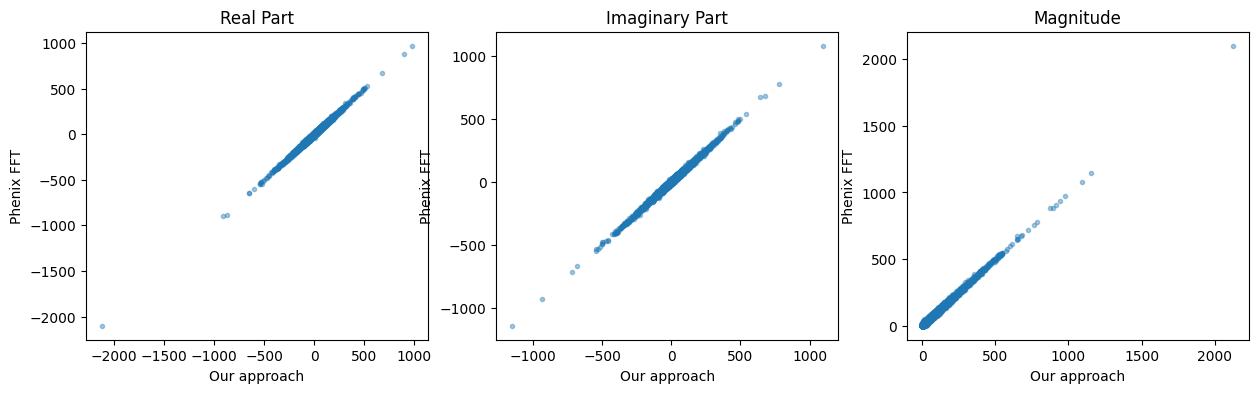

In [19]:
# Protein Part
comp_plot_complex(Fprotein_arr, Fcalc_complex, "Our approach", "Phenix FFT", dpi=100)

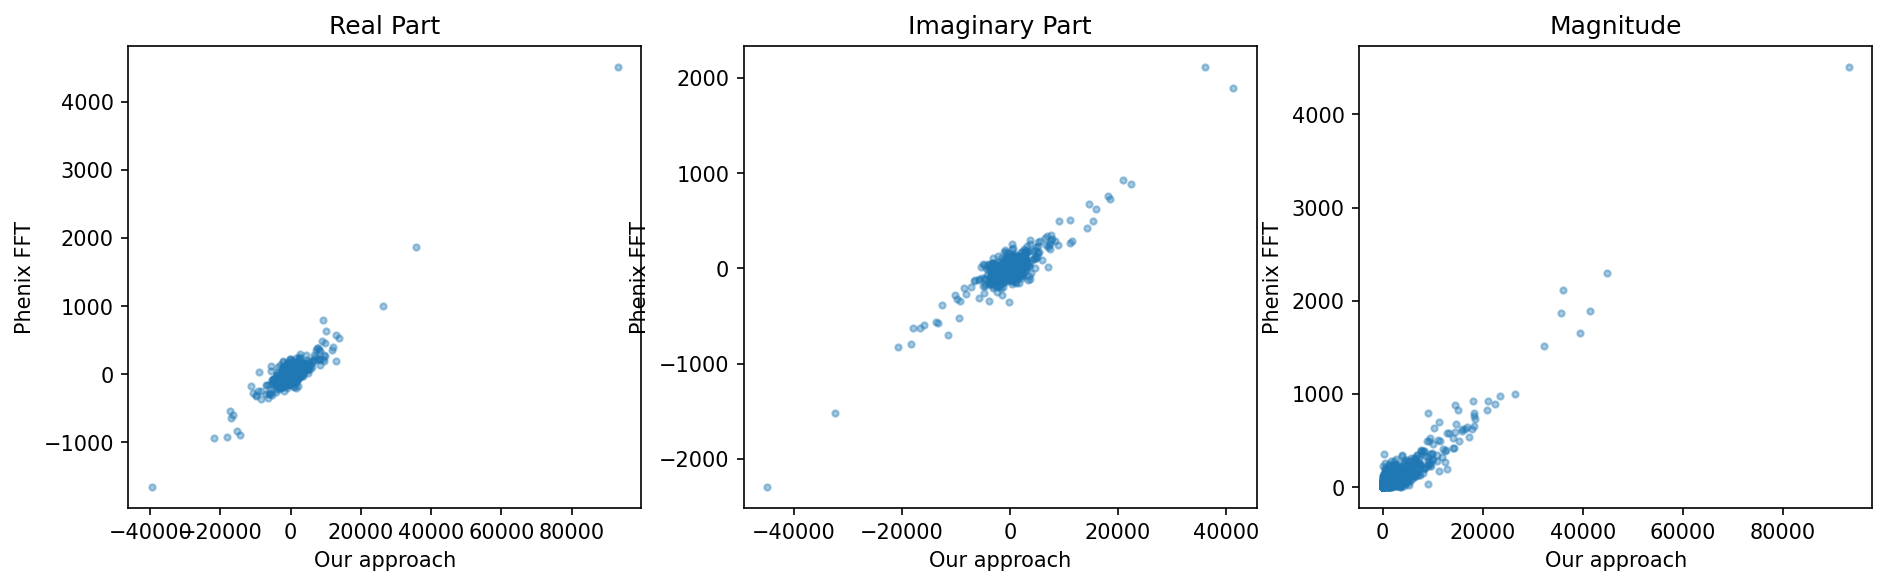

In [18]:
comp_plot_complex(Fsolvent_arr, Fmask_complex, "Our approach", "Phenix FFT", dpi=150)

#### Gradient descent for the scales

In [20]:
from SFC_Jax.utils import r_factor

In [27]:
def scale_train(optimizer, sfcalculator, n_steps=1000, loss_track=[], verbose=True):
    def scale_steptrain(optimizer, sfcalculator):
        Fmodel = sfcalculator.Calc_Ftotal(kall=kall, kaniso=kaniso, ksol=ksol, bsol=bsol)
        Fmodel_mag = torch.abs(Fmodel)
        loss = torch.sum((sfcalculator.Fo - Fmodel_mag)**2)
        r_work, r_free = r_factor(sfcalculator.Fo, Fmodel_mag, sfcalculator.rwork_id, sfcalculator.rfree_id)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return loss, r_work, r_free
    for k in range(n_steps):
        start_time = time.time()

        temp = scale_steptrain(optimizer, sfcalculator)
        loss_track.append([i.detach().cpu().numpy() for i in temp])
        time_this_round = round(time.time() - start_time, 3)
        str_ = "Time: " + str(time_this_round)

        if verbose:
            print("Scale", *loss_track[-1], str_, flush=True)
    return loss_track

In [28]:
loss_track = scale_train(optimizer, sfcalculator, n_steps=2000, loss_track=[], verbose=True)

Scale 2359468489.544759 0.7929723488711723 1.2518038256488366 Time: 0.041
Scale 1381169534.9203198 0.7532501564027207 1.088716543424231 Time: 0.009
Scale 745054949.9420867 0.7421624547659179 0.9822808484780907 Time: 0.009
Scale 362867736.33641016 0.7204502688073998 0.8795394606966807 Time: 0.008
Scale 157776008.08584803 0.6985892579636864 0.7902009029516632 Time: 0.008
Scale 67952216.76955406 0.6869479226360898 0.7258567887405833 Time: 0.008
Scale 45795111.404750794 0.6904231325709471 0.6928925503934671 Time: 0.009
Scale 50500638.73707329 0.710448563053207 0.722289062655206 Time: 0.009
Scale 72984491.33161972 0.7438553280963308 0.7790892283812242 Time: 0.012
Scale 103704009.76393303 0.7702333106758265 0.8307442716170614 Time: 0.008
Scale 135048159.96913806 0.7891127759537621 0.871302930063357 Time: 0.009
Scale 162278004.62588936 0.802719179875082 0.9004585456718193 Time: 0.009
Scale 182346361.20637843 0.8114933054866426 0.9197449730981075 Time: 0.008
Scale 193952289.4028353 0.816175290

In [30]:
print(kall)
print(kaniso)
print(ksol)
print(bsol)

tensor(0.9361, device='cuda:0', requires_grad=True)
tensor([-0.0170, -0.0076, -0.0127, -1.2057, -0.2516, -0.7643], device='cuda:0',
       requires_grad=True)
tensor(0.0177, device='cuda:0', requires_grad=True)
tensor(18.1952, device='cuda:0', requires_grad=True)


### Gradient Descent for the scales

In [14]:
import jax
import optax
import flax
import jax.numpy as jnp
import time

In [42]:
from SFC_Jax.utils import r_factor

In [68]:
initial_params = {
    'kall': jnp.array([1.0]),
    'kaniso': jax.random.normal(key=jax.random.PRNGKey(42), shape=[6])*0.01+0.01,
    'ksol': jnp.array([0.03]),
    'bsol': jnp.array([15.0]),    
}

In [69]:
def loss(params: optax.Params) -> jnp.ndarray:
    Fmodel = sfcalculator.Calc_Ftotal(kall=params['kall'], 
                                      kaniso=params['kaniso'], 
                                      ksol=params['ksol'], 
                                      bsol=params['bsol'])
    Fmodel_mag = jnp.abs(Fmodel)
    error = jnp.sum((sfcalculator.Fo - Fmodel_mag)**2)
    r_work, r_free = r_factor(sfcalculator.Fo, Fmodel_mag, sfcalculator.rwork_id, sfcalculator.rfree_id)
    return error, (r_work, r_free)

In [70]:
def fit(params: optax.Params, optimizer: optax.GradientTransformation, n_steps: int) -> optax.Params:
    opt_state = optimizer.init(params) 
    
    @jax.jit
    def step(params, opt_state):
        loss_value, grads = jax.value_and_grad(loss, has_aux=True)(params)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value

    for i in range(n_steps):
        start_time = time.time()
        params, opt_state, (loss_value, (r_work, r_free)) = step(params, opt_state)
        time_this_round = round(time.time() - start_time, 3)
        print(f'step {i}, loss: {loss_value}, R_work: {r_work}, R_free: {r_free}, time: {time_this_round}')
    return params

In [71]:
optimizer = optax.adam(learning_rate=1e-2)
params = fit(initial_params, optimizer, 2000)

step 0, loss: 8109787.0, R_work: 0.21615439653396606, R_free: 0.23999172449111938, time: 0.63
step 1, loss: 5287805.0, R_work: 0.18734516203403473, R_free: 0.20583246648311615, time: 0.001
step 2, loss: 5927056.0, R_work: 0.17658750712871552, R_free: 0.21054893732070923, time: 0.0
step 3, loss: 6325308.0, R_work: 0.1799534410238266, R_free: 0.21562443673610687, time: 0.0
step 4, loss: 5521498.0, R_work: 0.18341593444347382, R_free: 0.21362237632274628, time: 0.0
step 5, loss: 4938870.0, R_work: 0.1835298091173172, R_free: 0.20765602588653564, time: 0.0
step 6, loss: 5055672.5, R_work: 0.18267133831977844, R_free: 0.20491422712802887, time: 0.0
step 7, loss: 5393568.0, R_work: 0.18218189477920532, R_free: 0.20827381312847137, time: 0.0
step 8, loss: 5521361.0, R_work: 0.18260487914085388, R_free: 0.2068495899438858, time: 0.0
step 9, loss: 5497409.0, R_work: 0.1830790638923645, R_free: 0.20739948749542236, time: 0.0
step 10, loss: 5280594.0, R_work: 0.18251611292362213, R_free: 0.205583

In [72]:
params

{'bsol': DeviceArray([32.431297], dtype=float32),
 'kall': DeviceArray([0.9396501], dtype=float32),
 'kaniso': DeviceArray([-0.01623704, -0.00712131, -0.01210425, -0.25712097,
              -0.05600027, -0.14341982], dtype=float32),
 'ksol': DeviceArray([0.01823636], dtype=float32)}

In [51]:
sfcalculator.Fprotein_HKL = torch.tensor(Fcalc_complex, device=try_gpu(), dtype=torch.complex64)

In [52]:
kall = torch.tensor(1.0, device=try_gpu(), requires_grad=True)
kaniso = torch.normal(0.001, 0.001, size=[6], device=try_gpu(), requires_grad=True)
ksol = torch.tensor(0.3, device=try_gpu(), requires_grad=True)
bsol = torch.tensor(15.0, device=try_gpu(), requires_grad=True)

In [53]:
params = [kall, kaniso, ksol, bsol]
optimizer = torch.optim.Adam(params, lr=0.05)

In [54]:
loss_track = scale_train(optimizer, sfcalculator, n_steps=2000, loss_track=[], verbose=True)

Scale 2362679129.936879 0.7703731343888437 1.2386004382413518 Time: 0.011
Scale 1382787890.751635 0.7373640643693977 1.0759429894669335 Time: 0.009
Scale 745738409.422499 0.7324282219742781 0.9730798536035633 Time: 0.009
Scale 362935717.878269 0.7130820064667867 0.8734116272410787 Time: 0.009
Scale 157377258.09491217 0.6923293143764615 0.78478306967064 Time: 0.009
Scale 67264711.56535427 0.6814828499020628 0.7214018156614841 Time: 0.009
Scale 44973217.67225708 0.685728590430035 0.6890739705430816 Time: 0.008
Scale 49607678.578197196 0.7060947367071306 0.7183484918093542 Time: 0.009
Scale 72011914.71763179 0.739672608363055 0.7755141629463813 Time: 0.009
Scale 102682543.94318643 0.7661323616215401 0.8275242972419219 Time: 0.008
Scale 134061035.46630746 0.7851364135587567 0.8681127672683074 Time: 0.008
Scale 161337547.90838543 0.798811481389618 0.8974872744957532 Time: 0.009
Scale 181477974.05964866 0.8075826864840802 0.9167873630273163 Time: 0.012
Scale 193159817.4718702 0.8121613499337

In [55]:
print(kall)
print(kaniso)
print(ksol)
print(bsol)

tensor(0.9402, device='cuda:0', requires_grad=True)
tensor([-0.0139, -0.0052, -0.0094, -0.7558, -0.0383, -0.2181], device='cuda:0',
       requires_grad=True)
tensor(0.0176, device='cuda:0', requires_grad=True)
tensor(18.1234, device='cuda:0', requires_grad=True)
